<a href="https://colab.research.google.com/github/DavidkingMazimpaka/MediMatch/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Model for Drug Name Detection

## We'll use TensorFlow and Keras to build and train the neural network.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%pip install tensorflow --quiet

# Import necessary libraries
import os
import yaml
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from PIL import Image

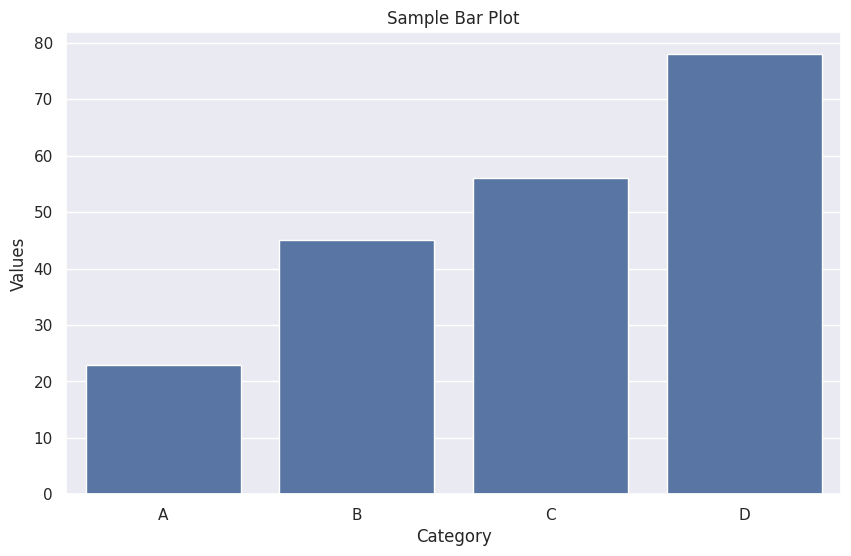

In [2]:
sns.set_theme(style="darkgrid", rc={"axes.unicode_minus": False})

# Set seeds for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Ensure Matplotlib uses the inline backend
%matplotlib inline

# Example usage of the imports (this part can be modified based on your specific use case)
# For demonstration purposes, we will load some sample data and plot it using Matplotlib and Seaborn

# Creating a sample DataFrame
data = pd.DataFrame({
    'Category': ['A', 'B', 'C', 'D'],
    'Values': [23, 45, 56, 78]
})

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Values', data=data)
plt.title('Sample Bar Plot')
plt.show()

In [3]:
from tensorflow.keras.regularizers import l2

def create_model(num_classes, input_shape=(224, 224, 3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [4]:
def load_data(train_dir, val_dir, test_dir, img_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2
    )
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_ds = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_ds = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_ds = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_ds, val_ds, test_ds

In [5]:
def compile_model(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [7]:
def train_model(model, train_ds, val_ds, epochs=40, save_period=10):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_checkpoint_{epoch:02d}.h5',
        save_weights_only=True,
        save_freq=save_period * len(train_ds)
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping, reduce_lr],
        verbose=2  # Detailed logging
    )

    return history

In [8]:
# Add this import at the top of your script
import matplotlib.pyplot as plt

# Define the plot_history function
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

Found 1276 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                            

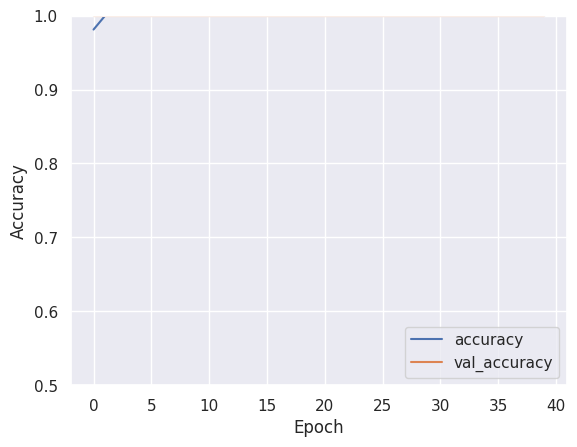

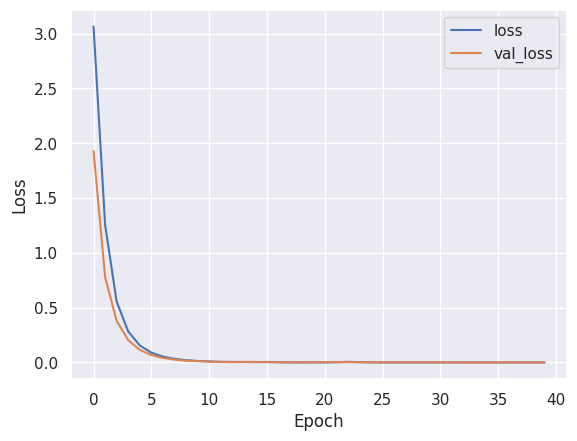


Final model saved as 'final_model.h5'

Evaluating model on test set...
6/6 [==============================] - 48s 9s/step - loss: 7.4153e-05 - accuracy: 1.0000
Test accuracy: 1.0000


In [9]:
# Dataset paths
train_dir = "/content/drive/MyDrive/MediMatch Initiative /Dataset/train"
val_dir = "/content/drive/MyDrive/MediMatch Initiative /Dataset/valid"
test_dir = "/content/drive/MyDrive/MediMatch Initiative /Dataset/test"

# Loading the datasets
train_ds, val_ds, test_ds = load_data(train_dir, val_dir, test_dir)

# Checking for overlap in datasets
def get_file_paths(directory_iterator):
    return set([os.path.basename(directory_iterator.filenames[i]) for i in range(len(directory_iterator.filenames))])

train_files = get_file_paths(train_ds)
val_files = get_file_paths(val_ds)
test_files = get_file_paths(test_ds)

assert len(train_files.intersection(val_files)) == 0, "Overlap found between training and validation sets!"
assert len(train_files.intersection(test_files)) == 0, "Overlap found between training and test sets!"
assert len(val_files.intersection(test_files)) == 0, "Overlap found between validation and test sets!"

# Create and train the model
num_classes = len(train_ds.class_indices)
model = create_model(num_classes)
compile_model(model)

print("Model summary:")
model.summary()

print("\nStarting training...")
history = train_model(model, train_ds, val_ds, epochs=40, save_period=10)

print("\nTraining complete. Plotting results...")
plot_history(history)

# Save the final model
model.save('final_model.h5')
print("\nFinal model saved as 'final_model.h5'")

# Evaluate the model on the test set
print("\nEvaluating model on test set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

1/1 [==============================] - 0s 224ms/step
Predicted class: images
Confidence: 1.00
1/1 [==============================] - 0s 53ms/step
Image: /content/drive/MyDrive/MediMatch Initiative /Dataset/test/images/20230812_214043_jpg.rf.0df6b253cf09bd47d9ffd72f8158b5d6.jpg
Predicted class: images
Confidence: 1.00

Image: /content/drive/MyDrive/MediMatch Initiative /Dataset/test/images/20230812_215916_jpg.rf.73cc868bb2038044a6820f8607aae04e.jpg
Predicted class: images
Confidence: 1.00

Image: /content/drive/MyDrive/MediMatch Initiative /Dataset/test/images/20230812_220806_jpg.rf.fcd789d33cef3a7206e33007a1326197.jpg
Predicted class: images
Confidence: 1.00

1/1 [==============================] - 0s 51ms/step


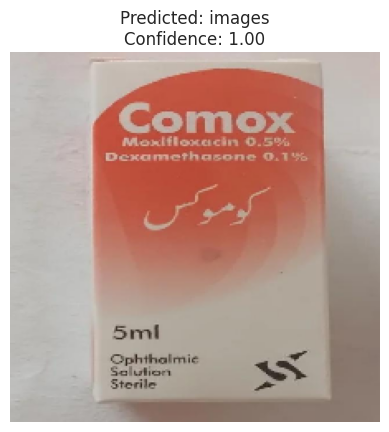

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the saved model
model = load_model('final_model.h5')

# Function to preprocess a single image
def preprocess_image(image_path, img_size=(224, 224)):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to make a prediction
def predict_image(image_path, model, class_indices):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index)]
    confidence = prediction[0][predicted_class_index]
    return predicted_class, confidence

# Get the class indices from the training dataset
class_indices = train_ds.class_indices

# Example usage
image_path = "/content/drive/MyDrive/MediMatch Initiative /Dataset/test/images/20230812_210244_jpg.rf.a2373a15c967eb6a157295e74fc71f45.jpg"
predicted_class, confidence = predict_image(image_path, model, class_indices)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# Function to make predictions on multiple images
def predict_multiple_images(image_paths, model, class_indices):
    results = []
    for image_path in image_paths:
        predicted_class, confidence = predict_image(image_path, model, class_indices)
        results.append({
            'image_path': image_path,
            'predicted_class': predicted_class,
            'confidence': confidence
        })
    return results

# Example usage for multiple images
image_paths = [
    "/content/drive/MyDrive/MediMatch Initiative /Dataset/test/images/20230812_214043_jpg.rf.0df6b253cf09bd47d9ffd72f8158b5d6.jpg",
    "/content/drive/MyDrive/MediMatch Initiative /Dataset/test/images/20230812_215916_jpg.rf.73cc868bb2038044a6820f8607aae04e.jpg",
    "/content/drive/MyDrive/MediMatch Initiative /Dataset/test/images/20230812_220806_jpg.rf.fcd789d33cef3a7206e33007a1326197.jpg"
]

predictions = predict_multiple_images(image_paths, model, class_indices)

for pred in predictions:
    print(f"Image: {pred['image_path']}")
    print(f"Predicted class: {pred['predicted_class']}")
    print(f"Confidence: {pred['confidence']:.2f}")
    print()

# Function to visualize predictions
def visualize_prediction(image_path, predicted_class, confidence):
    img = load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.show()

# Example usage of visualization
image_path = "/content/drive/MyDrive/MediMatch Initiative /Dataset/test/images/20230812_210244_jpg.rf.a2373a15c967eb6a157295e74fc71f45.jpg"
predicted_class, confidence = predict_image(image_path, model, class_indices)
visualize_prediction(image_path, predicted_class, confidence)